In [23]:
# Use compressed rank 15 SVD approximation and QR decomposition of each digit set for increased accuracy and less computational expense
# Import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from typing import Union
%matplotlib inline
#set seaborn plot style
sns.set_style('whitegrid')

In [2]:
# Load files containing handwritten digit image data
# Training data
Train = scipy.io.loadmat('C:/Users/Sakshi/Desktop/Projects/Image recognition model/azip.mat')['azip']

# Testing data
Test = scipy.io.loadmat('C:/Users/Sakshi/Desktop/Projects/Image recognition model/testzip.mat')['testzip']

# Correct labels for testing data
Correct = scipy.io.loadmat('C:/Users/Sakshi/Desktop/Projects/Image recognition model/dtest.mat')['dtest']

# Labels for training data
Labels = scipy.io.loadmat('C:/Users/Sakshi/Desktop/Projects/Image recognition model/dzip.mat')['dzip']

In [3]:
# Printing dimensions of each data matrix
print('Dimensions of train dataset: {}'.format(Train.shape))
print('Dimensions of test dataset: {}'.format(Test.shape))
print('Dimensions of test labels dataset: {}'.format(Correct.shape))
print('Dimensions of train labels dataset: {}'.format(Labels.shape))

Dimensions of train dataset: (256, 1707)
Dimensions of test dataset: (256, 2007)
Dimensions of test labels dataset: (1, 2007)
Dimensions of train labels dataset: (1, 1707)


In [4]:
# Sort digit images and labels according to numbers from 0 to 9
SortedLabels = np.sort(Labels)[0] # Sort Labels
ArgSort = np.argsort(Labels)[0] # Sort Labels and store sorted indexes
SortedTrain = Train[:,ArgSort] # Sort Digits

In [5]:
from itertools import groupby

In [6]:
# Printing digit set sizes for each digit - 0 to 9
DigitSetSizes = [len(list(group)) for key, group in groupby(SortedLabels)]
print('DigitSetSizes: {}'.format(DigitSetSizes))

DigitSetSizes: [319, 252, 202, 131, 122, 88, 151, 166, 144, 132]


In [7]:
# Define function to print first appearance of each digit in SortedDigits to verify properly sorted
def PrintFirstDigits(SortedTrain,DigitSetSizes):
    ind = 1
    j = 0
    for i in DigitSetSizes:
        plt.subplot(2,5,ind)
        plt.imshow(np.reshape(np.array(SortedTrain[:,j]),(16,16)),interpolation='nearest')
        ind+=1
        j += i
    print(SortedTrain[16][16])

-1.0


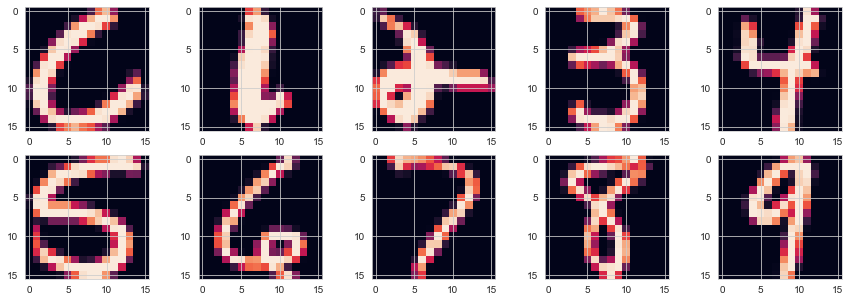

In [8]:
# Instantiate function and print results
plt.figure(figsize=(15,5))
PrintFirstDigits(SortedTrain,DigitSetSizes)

In [9]:
# Partition digits in SortedTrain into separate arrays according to their label
def PartitionDigits(SortedTrain,DigitSetSizes):
    PartitionedDigits = [np.zeros((1,1))]*10
    j = 0
    ind = 0
    for i in DigitSetSizes:    
        PartitionedDigits[ind] = SortedTrain[:,j:i+j]
        j+=i
        ind+=1
    return PartitionedDigits

In [10]:
# Instantiate function
PartitionedDigits = PartitionDigits(SortedTrain,DigitSetSizes)

In [11]:
# Print size of each digit set to verify
for i in range(10):
    print(PartitionedDigits[i].shape[1])


319
252
202
131
122
88
151
166
144
132


In [12]:
# Compress each digit set using a rank 15 SVD approximation and store results into list
Rank15SVD = [np.zeros((1,1))[0]]*10
PlotS = [np.zeros(1)]*10
k=15
for j in range(10):
    U,S,V = np.linalg.svd(PartitionedDigits[j],full_matrices=False)
    U = U[:,0:k] # Grab first 15 dominant singular column vectors for each digit set
    PlotS[j] = S
    Rank15SVD[j] = U # Store dominant singular column vectors

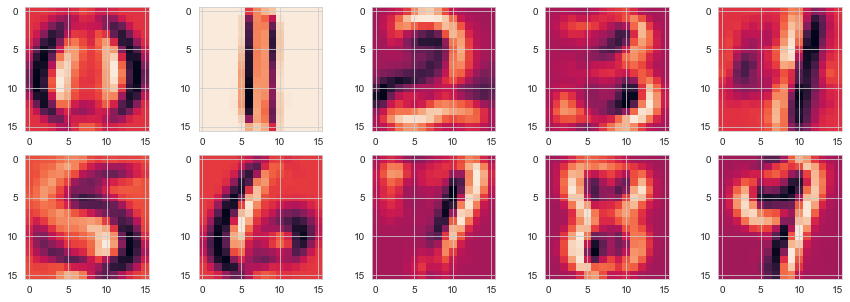

In [13]:
# Print rank 1 SVD approximations of each image (dominant singular column vector of each digit set)
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(np.reshape(Rank15SVD[i][:,1],(16,16)))

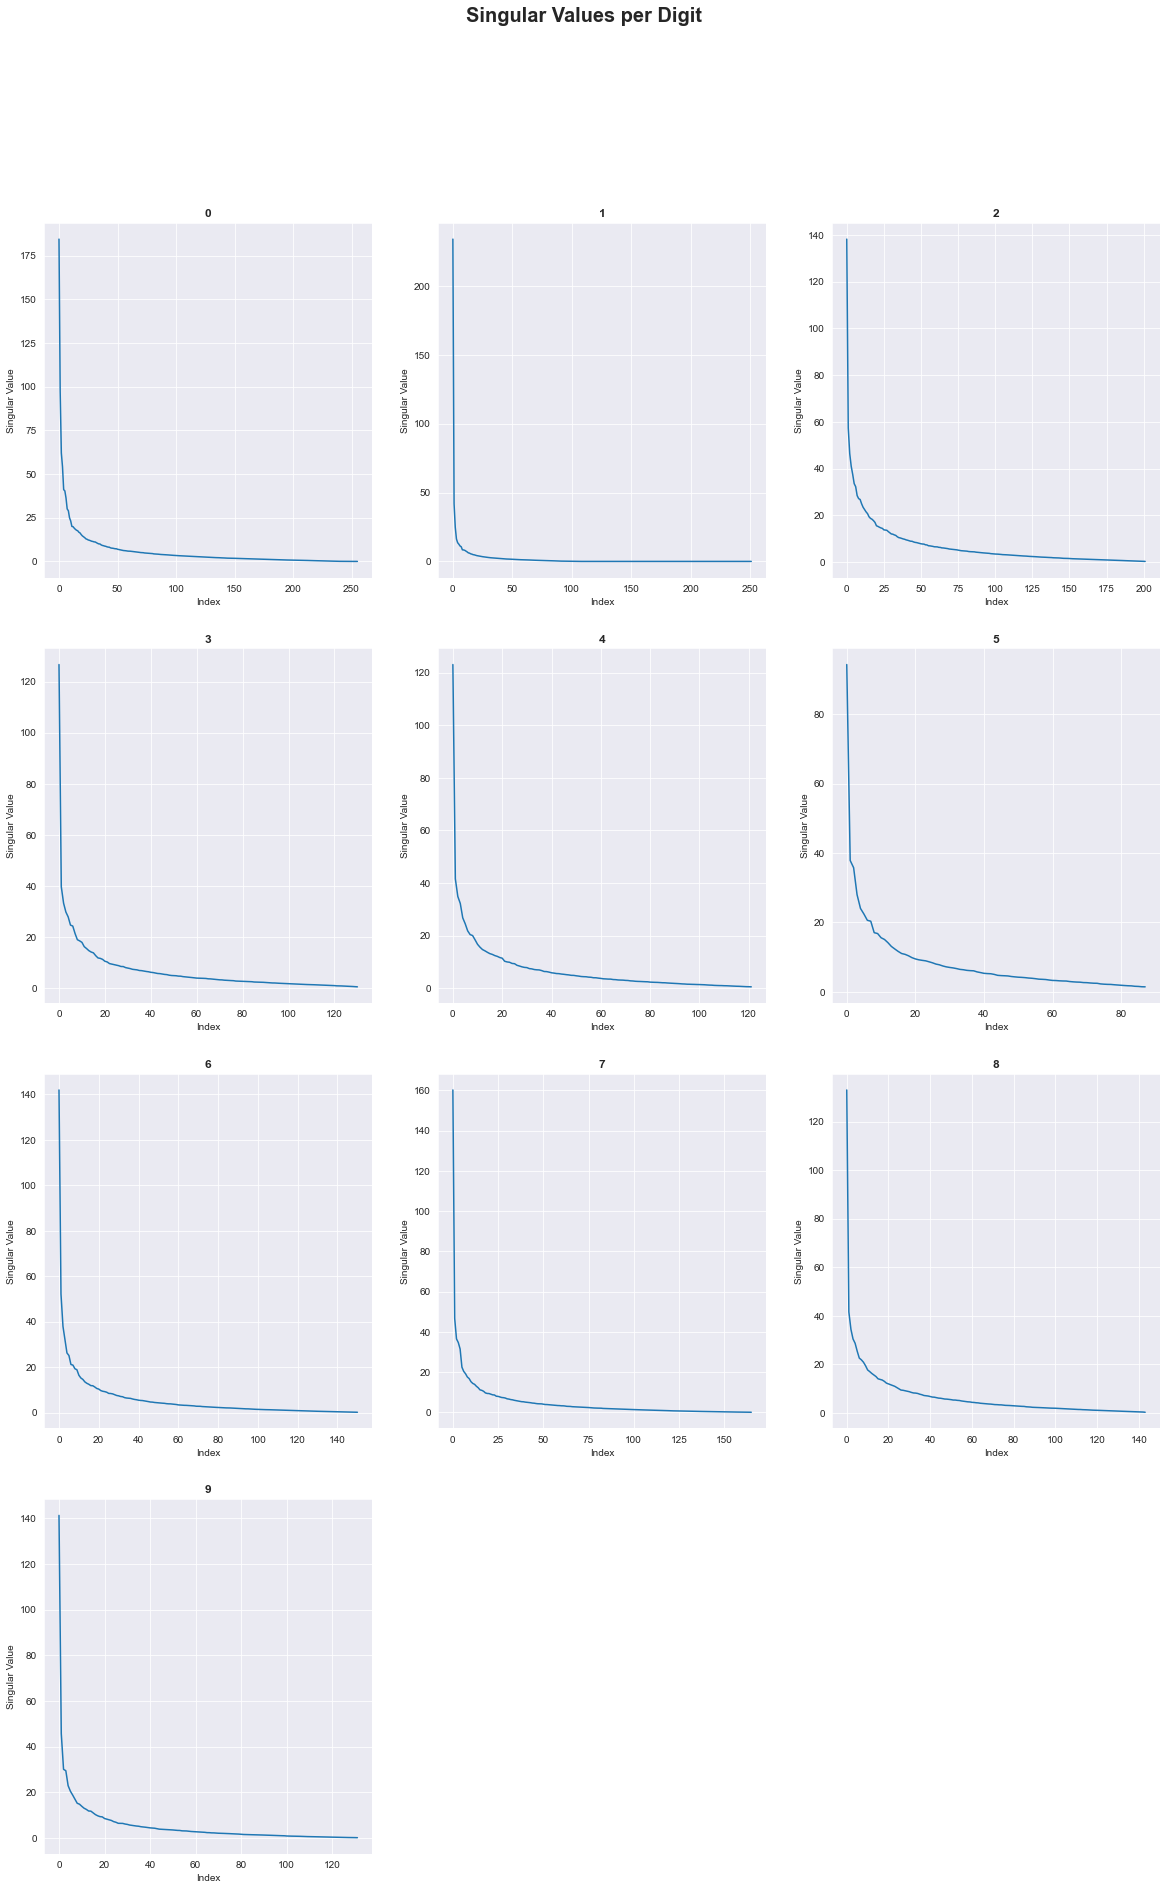

In [14]:
# Plot the Singular Values for each digit set
plt.figure(figsize=(20,30))
sns.set_style('darkgrid')
for i in range(10):
    PlotS[i] = pd.DataFrame(PlotS[i])
    plt.subplot(4,3,i+1)
    plt.plot(PlotS[i])
    plt.title('{}'.format(i),fontweight='bold')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.suptitle('Singular Values per Digit',fontweight='bold',fontsize=20)

In [15]:
# Calculate reduced QR decomposition of each digit set in Rank15SVD using numpy libraries
#QR = [[np.zeros((1,1))[0],np.zeros((1,1))[0]]]*10
#for i in range(10):
#    Q,R = np.linalg.qr(Rank15SVD[i])
#    QR[i] = [Q,R]

In [16]:
#Householder transformation algorithm to implement QR decomposition on each digit set in Rank15SVD
def householder_vectorized(a):
    
    v = a / (a[0] + np.copysign(np.linalg.norm(a), a[0]))
    v[0] = 1
    tau = 2 / (v.T @ v)
    
    return v,tau

def qr_decomposition(A: np.ndarray) -> Union[np.ndarray, np.ndarray]:
    m,n = A.shape
    R = A.copy()
    Q = np.identity(m)
    
    for j in range(0, n):
        # Apply Householder transformation.
        v, tau = householder_vectorized(R[j:, j, np.newaxis])
        
        H = np.identity(m)
        H[j:, j:] -= tau * (v @ v.T)
        R = H @ R
        Q = H @ Q
        
    return Q[:n].T, np.triu(R[:n])

    return Q[:n].T, R[:n]

In [17]:
#calculating QR decomposition and storing it in an array
QR = [[np.zeros((1,1))[0],np.zeros((1,1))[0]]]*10
for i in range(10):
    Q1,R1 = qr_decomposition(Rank15SVD[i])
    QR[i] = [Q1,R1]

In [18]:
# Solve system of equations for each digit set in PartitionedDigits and each testing digit in Test
Residuals = [0]*10
Predictions = [0]*len(Correct[0])
for i in range(len(Correct[0])):
    for j in range(10):
        x = np.matmul(np.matmul(np.linalg.inv(QR[j][1]),np.transpose(QR[j][0])),Test[:,i])
        Residuals[j] = np.linalg.norm(np.matmul(Rank15SVD[j],x)-Test[:,i],ord=2)
    Predictions[i] = np.argmin(np.array(Residuals))
    Residuals = [0]*10

In [19]:
# Create confusion matrix of results with rows as predictions and columns as correct labels
from sklearn.metrics import confusion_matrix
ConfusionMatrix = pd.DataFrame(confusion_matrix(Predictions,Correct[0]))
ConfusionMatrix

,0,1,2,3,4,5,6,7,8,9
0,355,0,9,3,1,4,3,0,3,0
1,0,260,1,0,1,1,1,1,0,3
2,2,0,179,3,0,2,0,1,1,0
3,0,0,3,148,0,9,0,0,4,0
4,1,3,2,1,186,0,2,3,0,3
5,0,0,1,8,1,140,1,0,2,0
6,0,1,0,0,3,0,162,0,0,0
7,0,0,1,1,3,0,0,141,1,4
8,0,0,2,2,0,1,1,0,153,2
9,1,0,0,0,5,3,0,1,2,165


In [20]:
# Accuracy results
Accuracy = [0]*10
for i in range(10):
    Accuracy[i] = ConfusionMatrix[i][i]/ConfusionMatrix[:][i].sum()
DF = pd.DataFrame(Accuracy,[0,1,2,3,4,5,6,7,8,9],columns=['Accuracy'])
DF

,Accuracy
0,0.988858
1,0.984848
2,0.904040
3,0.891566
4,0.930000
5,0.875000
6,0.952941
7,0.959184
8,0.921687
9,0.932203


C:\Users\Sakshi\anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<AxesSubplot:ylabel='Accuracy'>

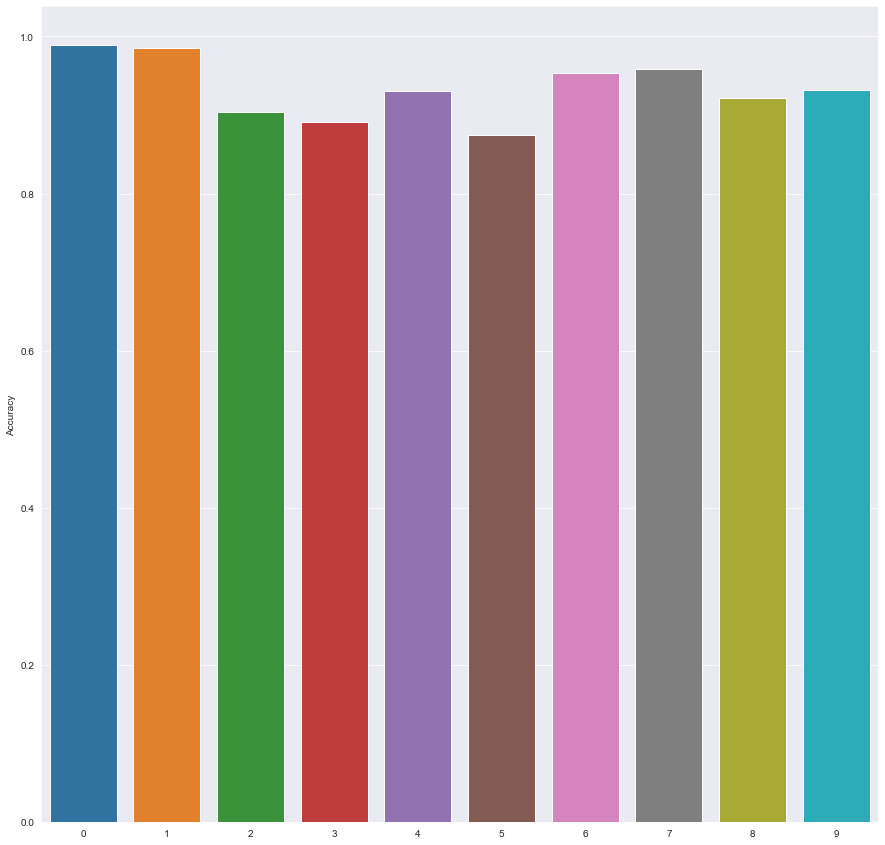

In [21]:
plt.figure(figsize=(15,15))
plt.xlabel='Digits'
plt.ylabel='Accuracy'
plt.suptitle=['Accuracy per Digit']
sns.barplot(y='Accuracy',x=[0,1,2,3,4,5,6,7,8,9],data=DF)

In [22]:
# Calculate overall model accuracy
TotalAccuracy = np.sum(np.diag(np.array(ConfusionMatrix)))/len(Correct[0])
print('Overall model accuracy: {}%'.format(round(TotalAccuracy*100),5))

Overall model accuracy: 94%
